## Setup

In [1]:
# DO NOT ALTER THIS CELL OR ITS TAG (parameters). It is used by papermill to fill in these parameters before executing the notebook.
DATA_PATH = "/home/it1123/dev_local/cse284/snp_clustering/tmp/clustering_pca.eigenvec"
K_HIGH = 14
RAND_SEED = 256
CLUSTERING_ITERS = 500

In [2]:
# Parameters
DATA_PATH = "/home/it1123/dev_local/cse284/snp_clustering/tmp/clustering_pca.eigenvec"
K_HIGH = 14
RAND_SEED = 256
CLUSTERING_ITERS = 500


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


In [4]:
# set directories
REPO_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(REPO_DIR, "data")
OUT_DIR = os.path.join(REPO_DIR, "out")
POPCODES_PATH = os.path.join(DATA_DIR, "igsr_samples.tsv")
RAND_SEED = 256
MARKERS = [
    "o", "v", "1", "2", "3", "4", "8", "s", "p", "*", "h", "H", "+", "x", "D", "d", "|", "_", 
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
]
COLORS = [
    'red', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'black', 'white',
    'gray', 'orange', 'pink', 'brown', 'purple', 'lime', 'olive', 'navy',
    'maroon', 'teal', 'aqua', 'silver', 'gold', 'indigo', 'violet', 'crimson',
    'coral', 'turquoise', 'salmon', 'khaki', 'plum', 'orchid', 'beige', 'mint',
    'lavender'
]

In [5]:
len(MARKERS)

30

## Data Loading/Preprocessing
We assume the existence of the file containing the coordinates of each sample in the eigenbasis (computed by `plink`)

### Load data & label columns

In [6]:
pca_data = pd.read_csv(DATA_PATH, delim_whitespace=True, header=None)
popcodes_df = pd.read_csv(POPCODES_PATH, sep="\t", header=0)
id_cols = ["family_id", "id"]
pop_cols = ["pop", "subpop"]
pc_cols = [f"pc{i+1}" for i in range(pca_data.shape[1] - 2)]
pca_data.columns =  id_cols + pc_cols

In [7]:
pca_data.head()

,family_id,id,pc1,pc2,pc3,pc4
0,HG00096,HG00096,-0.009763,0.027213,0.013751,0.015727
1,HG00097,HG00097,-0.014707,0.026629,0.011751,0.011084
2,HG00099,HG00099,-0.012137,0.025007,0.008817,0.014421
3,HG00100,HG00100,-0.012606,0.027683,0.014390,0.008601
4,HG00101,HG00101,-0.012874,0.022498,0.017722,0.007210


In [8]:
print (popcodes_df["Superpopulation code"].unique())
print()
print (popcodes_df['Population code'].unique())

['EUR' 'EAS' 'AMR' 'SAS' 'AFR' nan 'EUR,AFR']

['FIN' 'GBR' 'CHS' 'PUR' 'CDX' 'CLM' 'IBS' 'KHV' 'PEL' 'PJL' 'ACB' 'GWD'
 'ESN' 'BEB' 'MSL' 'ITU' 'STU' 'CEU' 'YRI' 'CHB' 'JPT' 'LWK' 'MXL' 'ASW'
 'TSI' 'GIH' 'GWJ' 'GWF' 'GWW' nan 'MKK' 'IBS,MSL']


### Map samples to population/subpopulation codes & get feature matrix $X$

In [9]:
#map samples to populations/subpopulation code
pca_data["pop"] = pca_data["id"].apply(lambda x: popcodes_df.loc[popcodes_df['Sample name'] == x, 'Superpopulation code'].squeeze())
pca_data["subpop"] = pca_data["id"].apply(lambda x: popcodes_df.loc[popcodes_df['Sample name'] == x, 'Population code'].squeeze())

pca_data = pca_data.loc[:, id_cols + pop_cols + pc_cols]
#get feature matrix for clustering
pop_data = pca_data.loc[:, id_cols + pop_cols]
X = pca_data.loc[:, pc_cols].to_numpy()


In [10]:
pop_data.head()

,family_id,id,pop,subpop
0,HG00096,HG00096,EUR,GBR
1,HG00097,HG00097,EUR,GBR
2,HG00099,HG00099,EUR,GBR
3,HG00100,HG00100,EUR,GBR
4,HG00101,HG00101,EUR,GBR


In [11]:
X[:5]

array([[-0.0097632 ,  0.0272129 ,  0.013751  ,  0.0157271 ],
       [-0.0147066 ,  0.0266289 ,  0.0117507 ,  0.0110837 ],
       [-0.0121369 ,  0.0250071 ,  0.00881677,  0.0144206 ],
       [-0.0126055 ,  0.0276831 ,  0.0143899 ,  0.00860087],
       [-0.0128736 ,  0.0224982 ,  0.0177218 ,  0.00721044]])

### create mapping between true population and point shape in clustering

In [12]:
pops_unique = pca_data['pop'].unique()
pop_shapes = dict(zip(pops_unique, MARKERS[:pops_unique.shape[0]]))

In [13]:
subpops_unique = pca_data['subpop'].unique()
subpop_shapes = dict(zip(subpops_unique, MARKERS[:subpops_unique.shape[0]]))
subpop_shapes

{'GBR': 'o',
 'FIN': 'v',
 'CHS': '1',
 'PUR': '2',
 'CDX': '3',
 'CLM': '4',
 'IBS': '8',
 'PEL': 's',
 'PJL': 'p',
 'KHV': '*',
 'IBS,MSL': 'h',
 'ACB': 'H',
 'GWD': '+',
 'ESN': 'x',
 'BEB': 'D',
 'MSL': 'd',
 'STU': '|',
 'ITU': '_',
 'CEU': 0,
 'YRI': 1,
 'CHB': 2,
 'JPT': 3,
 'LWK': 4,
 'ASW': 5,
 'MXL': 6,
 'TSI': 7,
 'GIH': 8}

## Data Exploration

### Contributions of SNPs to Principal Components

In [14]:
VAR_DATA_PATH = f"{DATA_PATH}.var"

var_data = pd.read_csv(VAR_DATA_PATH, delim_whitespace=True, header=None)
cols = ["chrom", "rsid", "allele1", "allele2"]  + [f"PC{i-3}_contribution" for i in range(4, var_data.shape[1])]
var_data.columns = cols
var_data['PC1_contribution_abs'] = np.abs(var_data['PC1_contribution'])
var_data = var_data.sort_values(by='PC1_contribution_abs', ascending=False)

In [15]:
var_data_best = var_data.iloc[:5000, :]
var_data_best['PC1_contribution_abs'].min()
#plt.barh(var_data_best['rsid'], var_data_best['PC1_contribution_abs'])

1.01957

### pairwise distance analysis

#### All Data

(array([4.63400e+03, 2.50960e+04, 7.31660e+04, 1.20174e+05, 1.44098e+05,
        1.51302e+05, 1.42808e+05, 1.26522e+05, 1.08050e+05, 8.95140e+04,
        7.23540e+04, 5.77800e+04, 4.61280e+04, 3.75620e+04, 3.07620e+04,
        2.67980e+04, 2.37560e+04, 2.13940e+04, 1.93660e+04, 1.80440e+04,
        1.81460e+04, 1.86120e+04, 1.96460e+04, 2.09820e+04, 2.27300e+04,
        2.51080e+04, 2.79680e+04, 3.06640e+04, 3.42900e+04, 3.91840e+04,
        4.48160e+04, 5.36820e+04, 6.76700e+04, 8.66440e+04, 1.13314e+05,
        1.51680e+05, 2.01218e+05, 2.65920e+05, 3.39364e+05, 4.17180e+05,
        4.69148e+05, 4.69668e+05, 4.04446e+05, 3.13708e+05, 2.28830e+05,
        1.66430e+05, 1.23684e+05, 9.40740e+04, 7.28640e+04, 5.73720e+04,
        4.49600e+04, 3.53080e+04, 2.86320e+04, 2.33260e+04, 1.98060e+04,
        1.74820e+04, 1.56880e+04, 1.43140e+04, 1.32300e+04, 1.26300e+04,
        1.26820e+04, 1.22760e+04, 1.22460e+04, 1.23940e+04, 1.17360e+04,
        1.08840e+04, 1.02800e+04, 9.93600e+03, 9.76

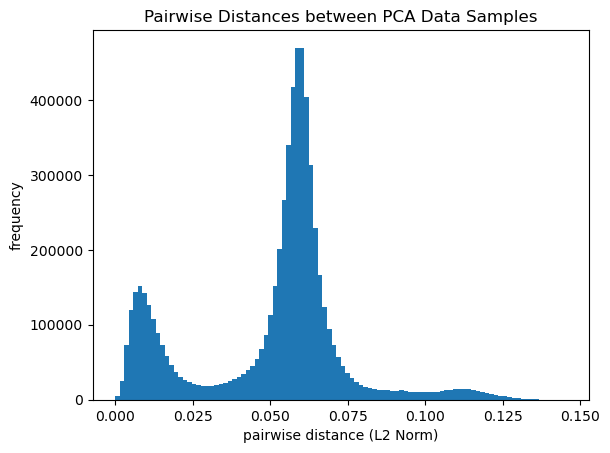

In [16]:
plt.title("Pairwise Distances between PCA Data Samples")
plt.xlabel("pairwise distance (L2 Norm)")
plt.xticks(np.arange(0, 0.5, 0.025))
plt.ylabel("frequency")
plt.hist(pairwise_distances(X).flatten(),bins=100)

#### Intra-Population

(array([5.040e+02, 1.600e+01, 1.100e+02, 2.520e+02, 5.080e+02, 8.540e+02,
        1.306e+03, 1.842e+03, 2.410e+03, 3.022e+03, 3.648e+03, 4.296e+03,
        4.906e+03, 5.430e+03, 5.952e+03, 6.404e+03, 6.798e+03, 7.138e+03,
        7.298e+03, 7.780e+03, 7.748e+03, 7.996e+03, 8.044e+03, 8.160e+03,
        8.068e+03, 8.070e+03, 7.906e+03, 7.956e+03, 7.486e+03, 7.446e+03,
        7.254e+03, 6.862e+03, 6.760e+03, 6.442e+03, 6.002e+03, 5.816e+03,
        5.494e+03, 5.138e+03, 4.742e+03, 4.452e+03, 4.112e+03, 3.894e+03,
        3.534e+03, 3.312e+03, 3.106e+03, 2.710e+03, 2.522e+03, 2.172e+03,
        2.150e+03, 1.828e+03, 1.712e+03, 1.578e+03, 1.386e+03, 1.256e+03,
        1.112e+03, 9.840e+02, 8.740e+02, 7.480e+02, 6.560e+02, 5.800e+02,
        5.380e+02, 4.100e+02, 4.020e+02, 3.020e+02, 2.520e+02, 2.300e+02,
        2.080e+02, 1.940e+02, 1.440e+02, 1.380e+02, 1.080e+02, 7.800e+01,
        9.000e+01, 5.000e+01, 5.400e+01, 6.000e+01, 4.200e+01, 3.000e+01,
        3.600e+01, 1.800e+01, 1.800e+0

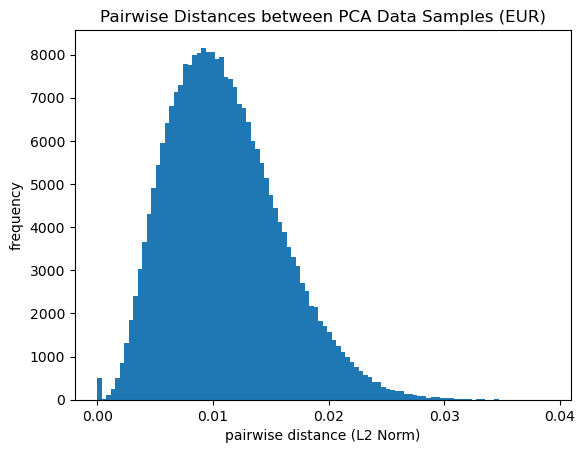

In [17]:
pop_code = "EUR"
X_pop = pca_data.loc[pca_data['pop'] == pop_code, pc_cols]
plt.title(f"Pairwise Distances between PCA Data Samples ({pop_code})")
plt.xlabel("pairwise distance (L2 Norm)")
plt.ylabel("frequency")
plt.xticks(np.arange(0, 0.5, 0.01))
plt.hist(pairwise_distances(X_pop).flatten(), bins=100)

## Clustering
#### Here we cluster the principal component data using $k$-means clustering and hierarchical clustering (Ward's method, agglomerative).

### $k$-Means Clustering

#### Find optimal $k$

In [18]:
# fit K-means, tune k
#silhouette scores as a measure of clustering quality
#sil scores are from -1 to 1
sil_scores = []
K = range(2, K_HIGH)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=CLUSTERING_ITERS, random_state=RAND_SEED)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(X, labels))

sil_scores = np.array(sil_scores)
optimal_k = K[np.argmax(sil_scores)]
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, max_iter=CLUSTERING_ITERS, random_state=RAND_SEED)
kmeans_optimal.fit(X)
print (f"optimal k: {optimal_k}; best silhouette score: {np.max(sil_scores)}")

optimal k: 6; best silhouette score: 0.7436697193910644


#### Plot silhouette score vs $k$

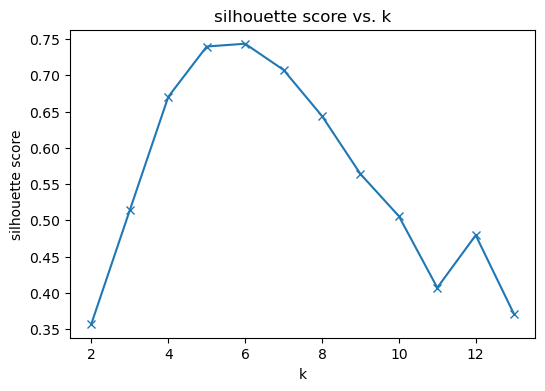

In [19]:
# plot clustering quality vs k
plt.figure(figsize=(6, 4))
plt.plot(K, sil_scores, marker='x')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('silhouette score vs. k')
plt.show()

#### Plot optimal clustering

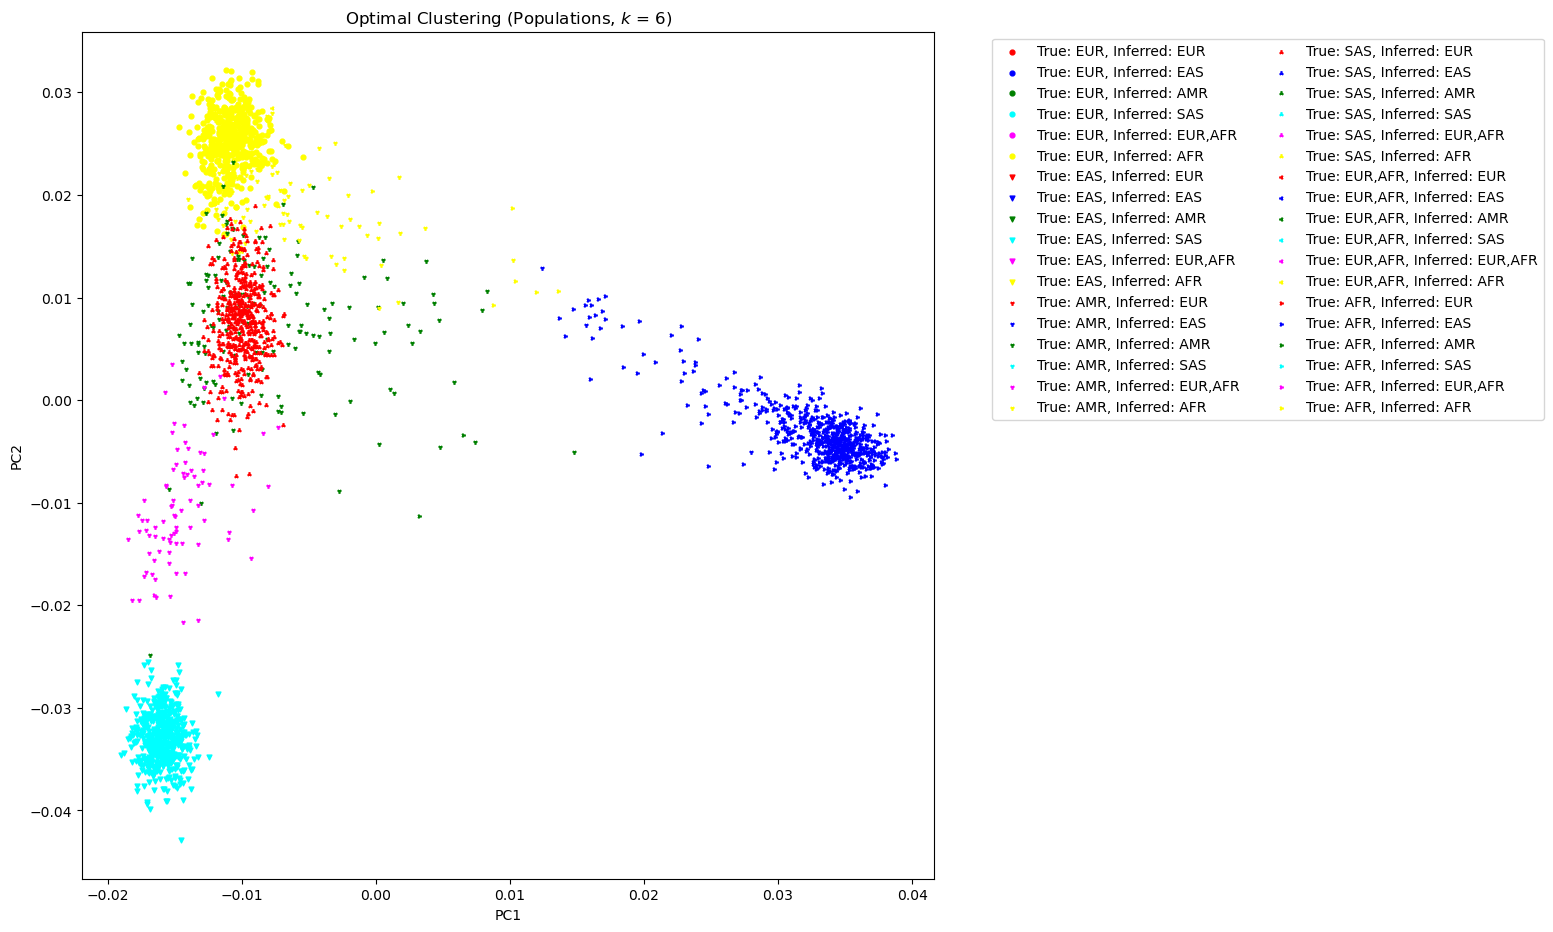

In [20]:
pca_data['inferred_assignment'] = kmeans_optimal.labels_
plt.figure(figsize=(11, 11))
plt.title(f'Optimal Clustering (Populations, $k$ = {optimal_k})')
plt.xlabel("PC1")
plt.ylabel("PC2")
for true_pop in pops_unique:
    for inferred_assignment in range(kmeans_optimal.labels_.max() + 1):
        # Select points that have true population = true_pop and inferred pop = inferred assignment
        mask = (pca_data['pop'] == true_pop) & (pca_data['inferred_assignment'] == inferred_assignment)

        #X has the same ordering as pca_data
        #we are naively selecting the first two coordinates because the first two PCs likely will dominate the coordinate variance
        selected_points = X[mask, :]
        
        # Plot selected points with the corresponding marker and color
        plt.scatter(selected_points[:, 0], selected_points[:, 1], s=12, marker=pop_shapes[true_pop], color=COLORS[inferred_assignment], label=f"True: {true_pop}, Inferred: {pops_unique[inferred_assignment]}")
plt.legend(bbox_to_anchor=(1.06, 1), loc='upper left', ncol=2)


### Does optimal $k$-means clustering capture subpopulation structure?

In [21]:
sil_scores_subpop = []
K = range(20, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=CLUSTERING_ITERS, random_state=RAND_SEED)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores_subpop.append(silhouette_score(X, labels))

sil_scores_subpop = np.array(sil_scores_subpop)
optimal_k_subpop = K[np.argmax(sil_scores_subpop)]
kmeans_optimal_subpop = KMeans(n_clusters=optimal_k_subpop, init='k-means++', n_init=10, max_iter=300, random_state=RAND_SEED)
kmeans_optimal_subpop.fit(X)
print (f"optimal k: {optimal_k_subpop}; best silhouette score: {np.max(sil_scores_subpop)}")

optimal k: 20; best silhouette score: 0.26561105230969506


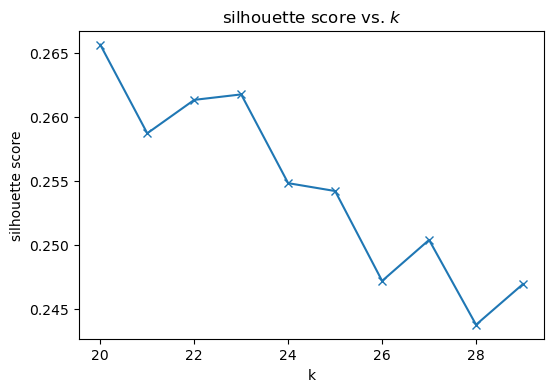

In [22]:
# plot clustering quality vs k
plt.figure(figsize=(6, 4))
plt.plot(K, sil_scores_subpop, marker='x')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('silhouette score vs. $k$')
plt.show()

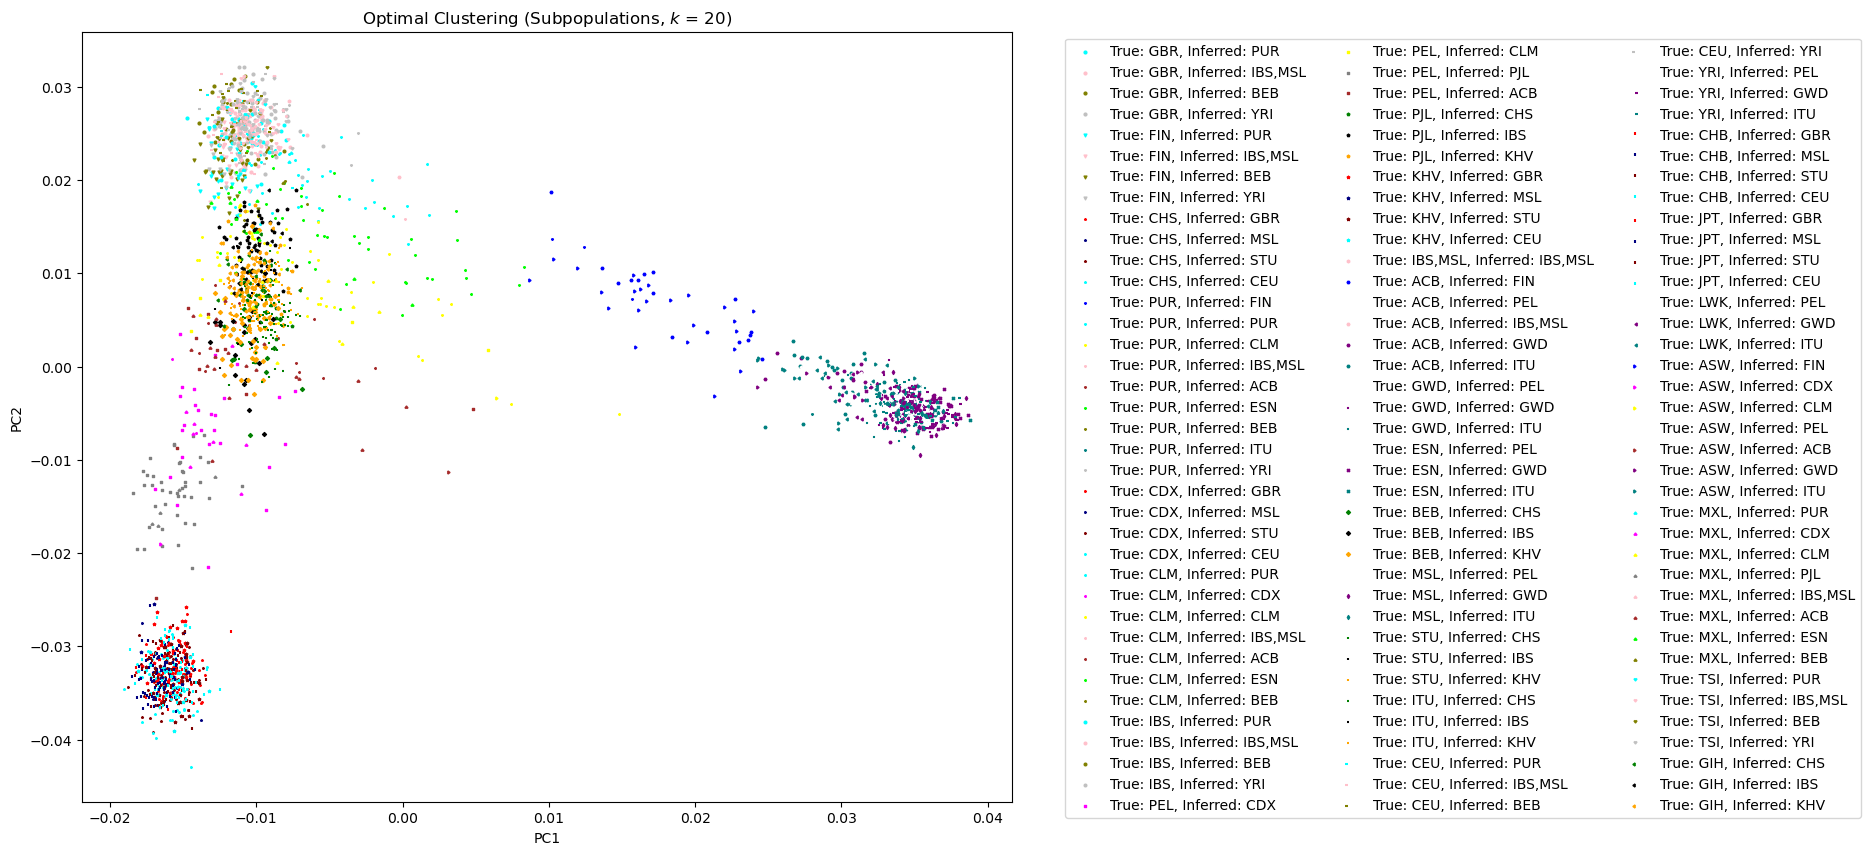

In [23]:

pca_data['inferred_assignment'] = kmeans_optimal_subpop.labels_
plt.figure(figsize=(12, 10))
plt.title(f'Optimal Clustering (Subpopulations, $k$ = {optimal_k_subpop})')
plt.xlabel("PC1")
plt.ylabel("PC2")
for true_subpop in subpops_unique:
    for inferred_assignment in range(kmeans_optimal_subpop.labels_.max() + 1):
        # Select points that have true population = true_pop and inferred pop = inferred assignment
        mask = (pca_data['subpop'] == true_subpop) & (pca_data['inferred_assignment'] == inferred_assignment)

        #X has the same ordering as pca_data
        #we are naively selecting the first two coordinates because the first two PCs likely will dominate the variation
        selected_points = X[mask, :]
        if selected_points.shape[0] == 0: continue
        # plot selected pts with the corresponding marker and color
        plt.scatter(selected_points[:, 0], selected_points[:, 1], s=4, marker=subpop_shapes[true_subpop], color=COLORS[inferred_assignment], label=f"True: {true_subpop}, Inferred: {subpops_unique[inferred_assignment]}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

##### Analysis

In [24]:
#what's the number of true subpopulations in our data?
num_pops = pca_data['pop'].unique().shape[0]
num_subpops = pca_data['subpop'].unique().shape[0]
num_pops, num_subpops

(6, 27)

### Hierarchical Clustering

In [25]:
def plt_dendrogram(hier_instance, distance_threshold, Z, method_name, p=6, truncate_mode='level', show_contracted=True, fs=5):
    plt.figure(figsize=(10, 7))
    dendrogram(Z, p=p, truncate_mode=truncate_mode, show_contracted=show_contracted)
    plt.title(f'Cluster Hierarchy ({method_name} linkage); $k$={hier_instance.n_clusters_}, d_thres={distance_threshold}')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.xticks(fontsize=fs, rotation=90)
    plt.legend()
    plt.show()

def tune_hier(linkage='ward', dt_low=0, dt_high=1, inc=0.02):
    sil_scores_tune = []
    for dt in np.arange(0, 1 + inc, inc):
        hier_tune = AgglomerativeClustering(linkage=linkage, n_clusters=None, distance_threshold=dt, compute_full_tree=True)
        hier_tune.fit(X)
        if np.unique(hier_tune.labels_).shape[0] < 2 or np.unique(hier_tune.labels_).shape[0] >= X.shape[0]:
            print ("cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold")
            sil_scores_tune.append(-1)
        else:
            sil_score_hier_tune = silhouette_score(X, hier_tune.labels_)
            sil_scores_tune.append(sil_score_hier_tune)
    sil_scores_tune = np.array(sil_scores_tune)
    optimal_dt = np.argmax(sil_scores_tune) * inc
    hier_best = AgglomerativeClustering(linkage=linkage, n_clusters=None, distance_threshold=optimal_dt, compute_full_tree=True)
    hier_best.fit(X)
    print ("done")
    print (f"optimal k: {hier_best.n_clusters_}; optimal distance threshold: {optimal_dt}; silhouette score: {silhouette_score(X, hier_best.labels_)}")
    return hier_best, sil_scores_tune, optimal_dt

def plt_sil_scores(method_name, sil_scores, inc=0.01, s=2):
    inc = 0.01
    xt = np.arange(0, 1 + inc, inc)
    plt.figure(figsize=(10,7))
    plt.title(f"Silhouette Score vs. Distance Threshold ({method_name} linkage)")
    plt.xlabel("distance threshold")
    plt.ylabel("Silhouette Score")
    plt.xlim([0, 1])
    plt.scatter(xt, sil_scores, s=s)

#### Using Ward Linkage

In [26]:
hier_ward, sil_scores_ward, optimal_dt_ward = tune_hier(linkage='ward', dt_low=0, dt_high=1, inc=0.01)

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


done
optimal k: 6; optimal distance threshold: 0.29; silhouette score: 0.7337131321988386


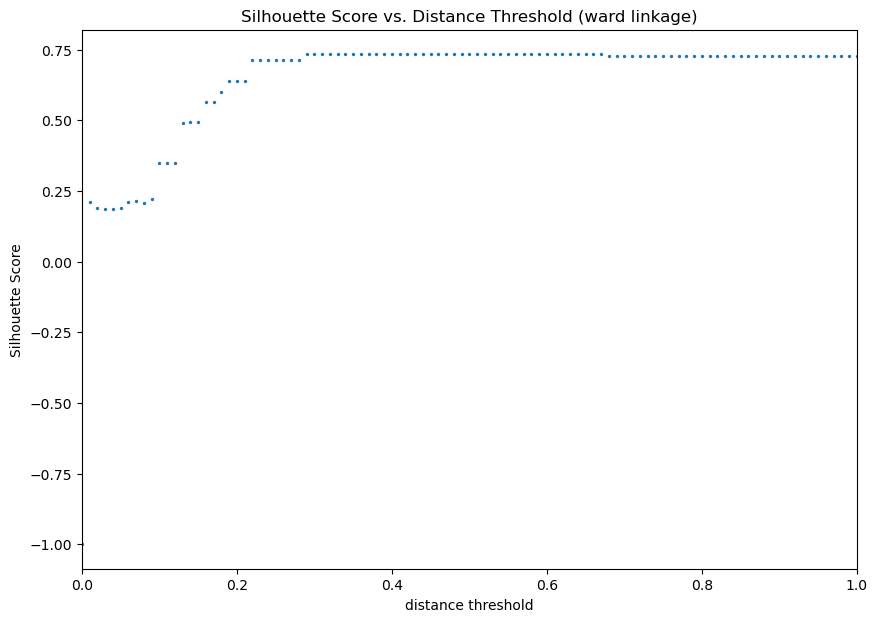

In [27]:
plt_sil_scores('ward', sil_scores_ward, inc=0.01, s=2)

In [28]:
Z_ward = linkage(X, 'ward')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


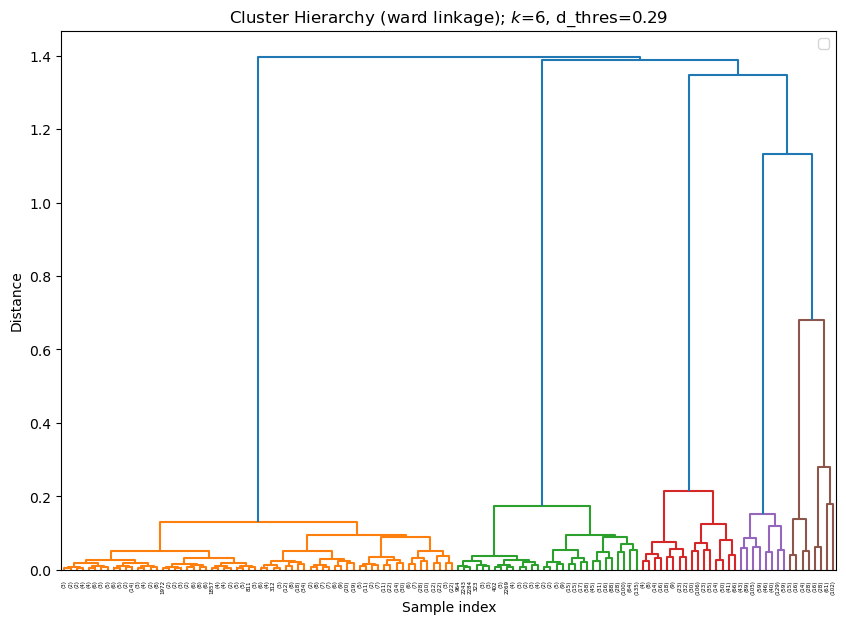

In [29]:
plt_dendrogram(hier_ward, optimal_dt_ward, Z_ward, 'ward', p=6, truncate_mode='level', show_contracted=True, fs=4)

In [30]:
hier_ward.n_clusters_

6

#### Using Average Linkage

In [31]:
hier_avg, sil_scores_avg, optimal_dt_avg = tune_hier(linkage='average', dt_low=0, dt_high=1, inc=0.01)

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
done
optimal k: 6; optimal distance threshold: 0.04; silhouette score: 0.7296699689645441


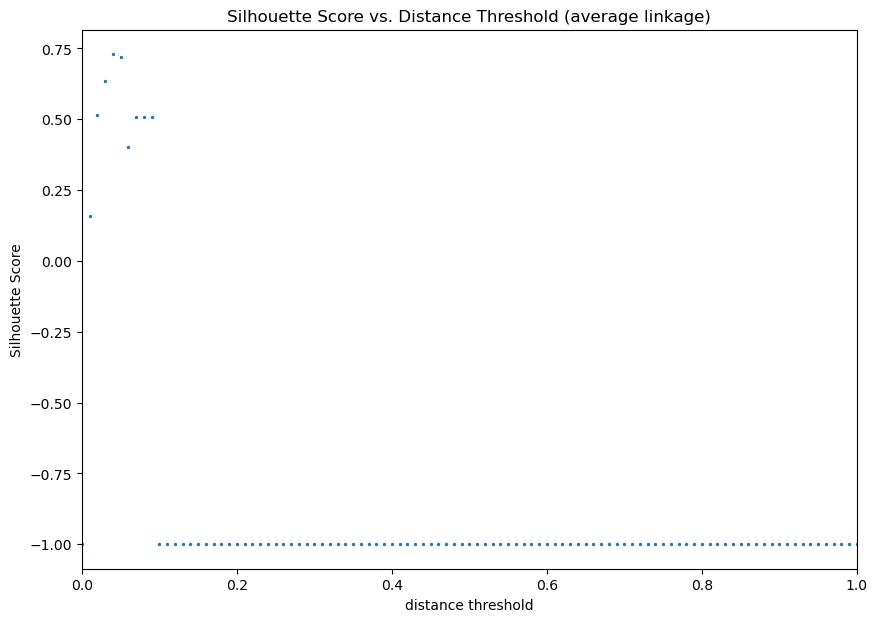

In [32]:
plt_sil_scores('average', sil_scores_avg, inc=0.01, s=2)

In [33]:
hier_avg.n_clusters_

6

In [34]:
Z_avg = linkage(X, 'average')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


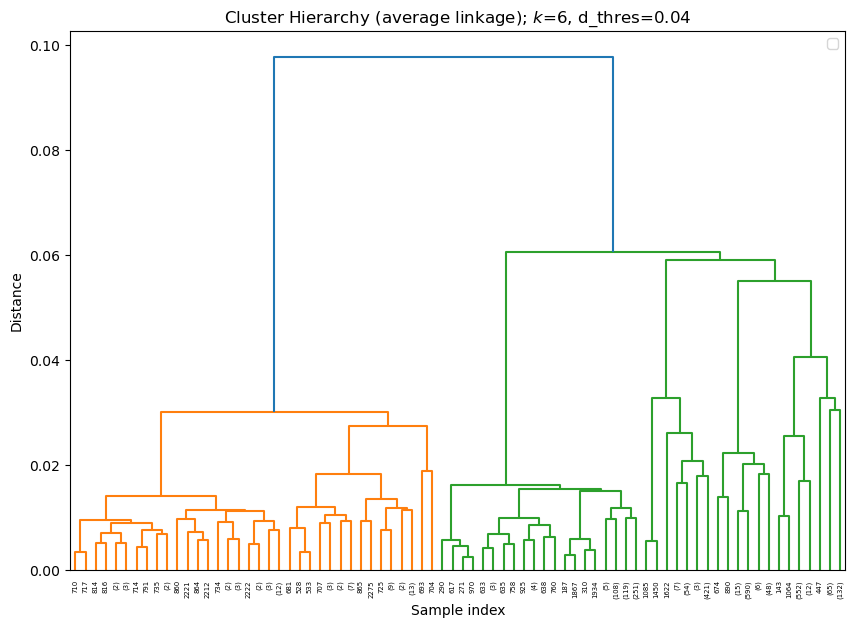

In [35]:
plt_dendrogram(hier_avg, optimal_dt_avg, Z_avg, 'average', p=6, truncate_mode='level', show_contracted=True)

#### Using Single Linkage

In [36]:
#this linkage does not even work, it just puts everything into one cluster unless distance threshold is super super small
hier_single, sil_scores_single, optimal_dt_single = tune_hier(linkage='single', dt_low=0, dt_high=1, inc=0.01)

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determi

optimal k: 2; optimal distance threshold: 0.02; silhouette score: 0.35717981385887193


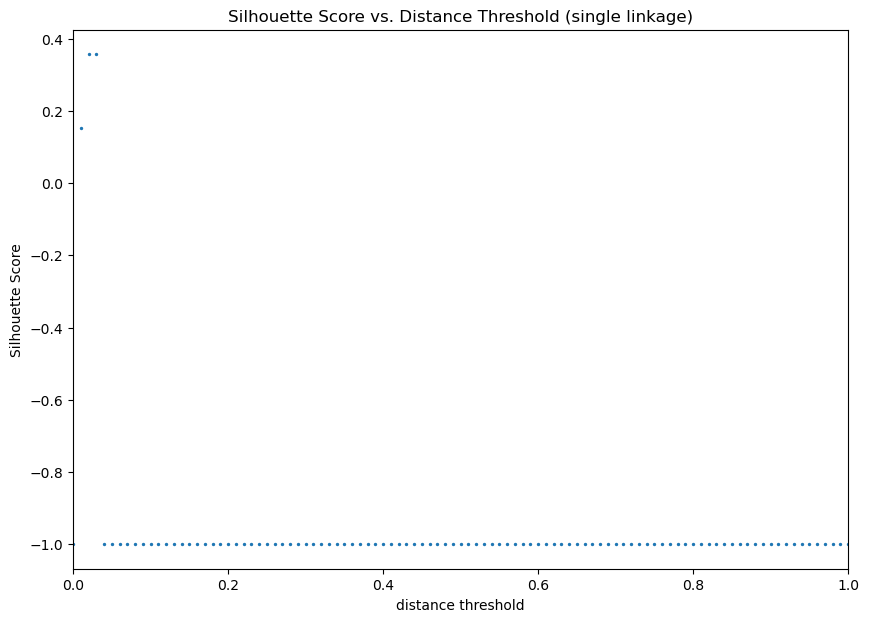

In [37]:
plt_sil_scores('single', sil_scores_single, inc=0.01, s=2)

In [38]:
hier_single.n_clusters_

2

In [39]:
Z_single = linkage(X, 'single')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


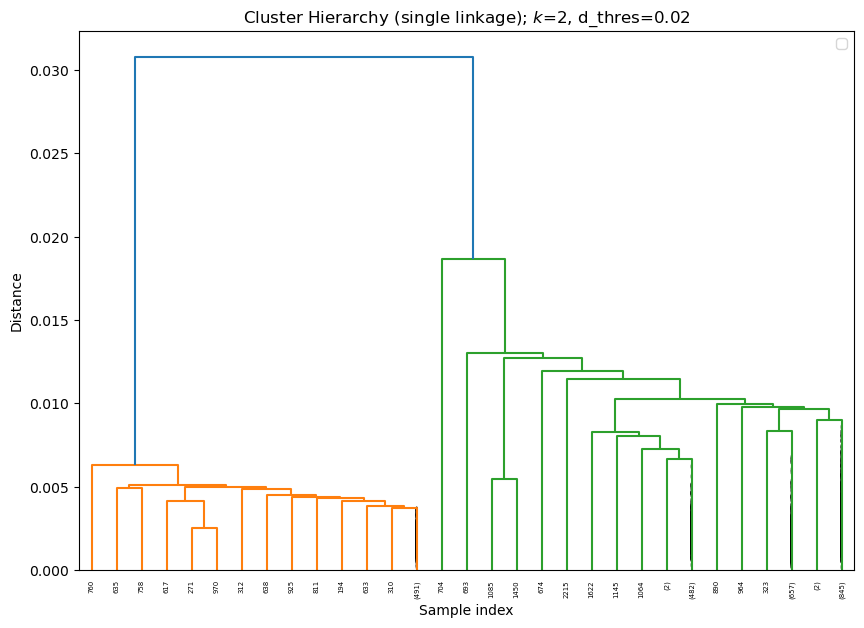

In [40]:
plt_dendrogram(hier_single, optimal_dt_single, Z_single, 'single', p=10, truncate_mode='level', show_contracted=True)

#### Using complete linkage

In [41]:
#this linkage does not even work, it just puts everything into one cluster unless distance threshold is super super small
hier_complete, sil_scores_complete, optimal_dt_complete = tune_hier(linkage='complete', dt_low=0, dt_high=1, inc=0.01)

cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold


cannot compute silhouette score, determined number of clusters is too small/big. Consider increasing distance threshold
done
optimal k: 7; optimal distance threshold: 0.07; silhouette score: 0.6626838369622513


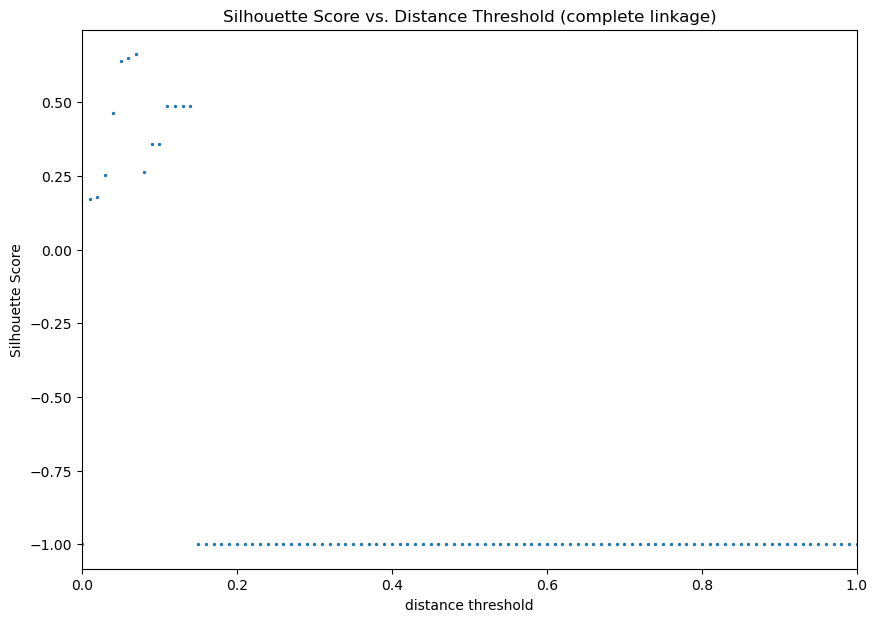

In [42]:
plt_sil_scores('complete', sil_scores_complete, inc=0.01, s=2)

In [43]:
hier_complete.n_clusters_

7

In [44]:
Z_complete = linkage(X, 'complete')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


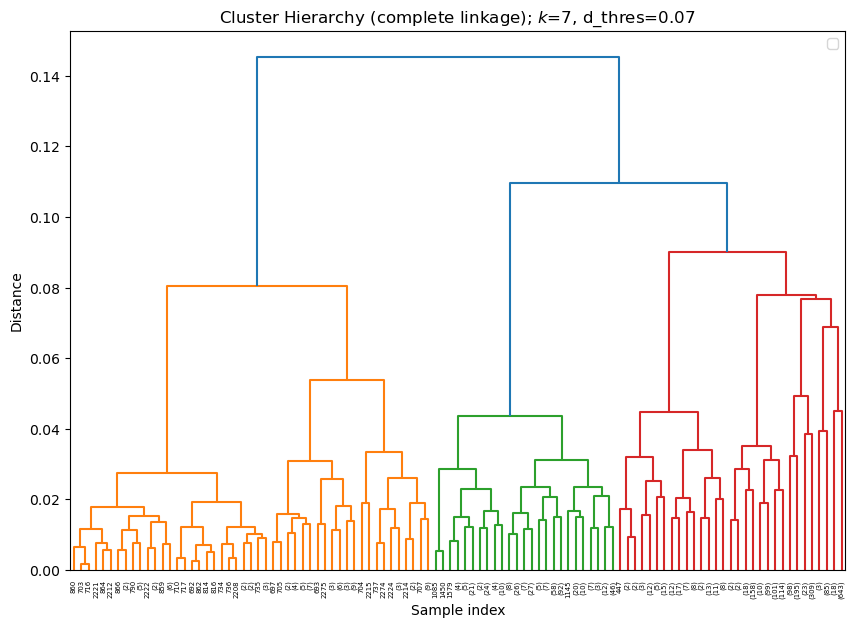

In [45]:
plt_dendrogram(hier_complete, optimal_dt_complete, Z_complete, 'complete', p=6, truncate_mode='level', show_contracted=True)